## Import

In [ ]:
!pip install transformers
!pip install beautifulsoup4

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import BertTokenizer
import torch
import numpy as np

from tqdm import tqdm
import re

path = './data'

path_train = path + '/ConvAbuse_dataset/ConvAbuse_train.json'
path_dev = path + '/ConvAbuse_dataset/ConvAbuse_dev.json'
path_test = path + '/ConvAbuse_dataset/ConvAbuse_test.json'

convAbuse = True

## Load Data and Preprocessing

In [20]:
df = pd.read_json(path_train, orient='index')
df = df[['text', 'hard_label','soft_label']]

df_dev = pd.read_json(path_dev, orient='index')
df_dev = df_dev[['text', 'hard_label', 'soft_label']]

df_test = pd.read_json(path_test, orient='index')
df_test = df_test[['text', 'hard_label', 'soft_label']]

In [2]:
import nltk
import string
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocessing(text, language = 'en'):
    text = text.lower()
    text = re.sub('<user>','', text)
    text = re.sub('rt','', text)
    text = re.sub('<url>','', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    if language == 'ar':
        stop_words = set(stopwords.words('arabic'))
    else:
        stop_words = set(stopwords.words('english'))

    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]
    return tokens_without_sw
    #print(tokens_without_sw)

def clean_sentences(a):
    #sobstitute the keywords with a point to allow split in sentences
    a = a.replace('"prev_agent": ', ".")
    a = a.replace(', "prev_user":', ".")
    a = a.replace(', "agent":', ".")
    a = a.replace(', "user":', ".")
    a = a.replace('"', "")
    a = a.replace('{', "")
    a = a.replace('}', "")
    return a

def clear_html_sintax(text):
    soup = BeautifulSoup(text)
    # get text
    return soup.get_text()

def clear_text(tweets):
    text_clear = []
    for sentence in tweets:
        text = ''
        for token in sentence:
            text += (token + ' ')
        text_clear.append(text)
    return text_clear

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [21]:
from bs4 import BeautifulSoup

if convAbuse:
    df['tokens'] = df['text'].apply(lambda x: clean_sentences(x))
    df['tokens'] = df['tokens'].apply(lambda x: clear_html_sintax(x))

    df_dev['tokens'] = df_dev['text'].apply(lambda x: clean_sentences(x))
    df_dev['tokens'] = df_dev['tokens'].apply(lambda x: clear_html_sintax(x))

    df_test['tokens'] = df_test['text'].apply(lambda x: clean_sentences(x))
    df_test['tokens'] = df_test['tokens'].apply(lambda x: clear_html_sintax(x))

#train
print(f'Preprocessing Train...')
if convAbuse:
    df['tokens'] = df['tokens'].apply(lambda x: preprocessing(x))
else:
    df['tokens'] = df['text'].apply(lambda x: preprocessing(x))
df['text_clear'] = clear_text(df['tokens'])

#dev
print(f'Preprocessing Dev...')
if convAbuse:
    df_dev['tokens'] = df_dev['tokens'].apply(lambda x: preprocessing(x))
else:
    df_dev['tokens'] = df_dev['text'].apply(lambda x: preprocessing(x))
df_dev['text_clear'] = clear_text(df_dev['tokens'])

#test
print(f'Preprocessing Test...')
if convAbuse:
    df_test['tokens'] = df_test['tokens'].apply(lambda x: preprocessing(x))
else:
    df_test['tokens'] = df_test['text'].apply(lambda x: preprocessing(x))
df_test['text_clear'] = clear_text(df_test['tokens'])

<ipython-input-2-310d65b4c0ae>:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)
<ipython-input-2-310d65b4c0ae>:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)
<ipython-input-2-310d65b4c0ae>:37: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text)


Preprocessing Train...
Preprocessing Dev...
Preprocessing Test...


In [22]:
def get_dataset_labels(df, columns = ['hard_label','soft_label_0','soft_label_1', 'agreement']):
  """
  df: dataframe to elaborate
  colums: list of output columns
  ______________________________
  Extract two columns from the soft-label column to represent disagreement on the positive and negative label.
  Add a "disagreemen" column with boolean values (1 for agreement, 0 for disagreement)
  Rename the column "text" in "original text" to distiguish with the token-column "text"
  """
  df['soft_label_0']= df['soft_label'].apply(lambda x: x['0'])
  df['soft_label_1']= df['soft_label'].apply(lambda x: x['1'])
  df['agreement'] = df['soft_label_0'].apply(lambda x : int(x==0 or x==1))
  return df

df = get_dataset_labels(df)
df_dev = get_dataset_labels(df_dev)
df_test = get_dataset_labels(df_test)

## M-BERT HATE Model

### Dataloader creation

In [ ]:
import torch
import numpy as np
#from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
labels = {0:0, 1:1}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['hard_label']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 128, truncation=True,
                                return_tensors="pt") for text in df['text_clear']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

import random

import torch.nn as nn

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.6):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        #self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        #self.linear.weight.data.normal_(mean=0.0, std=1.0)

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigmoid(linear_output)

        return final_layer

In [ ]:
EPOCHS = 5
model = BertClassifier()
LR = 2e-5

### Training function

In [8]:
random.seed(2)

def train_and_evaluate(model, train_data, val_data, test_data, epochs, lr=LR):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=16, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    class_weights = []

    for sample in training_data['hard_label'].value_counts().values:
        class_weights.append(1 - (sample / training_data.shape[0]))

    #class_weights = [class_weights[1], class_weights[0]]

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    print(class_weights)
    #criterion = nn.CrossEntropyLoss(weight = class_weights)

    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer = torch.optim.Adam(model.parameters(), lr= LR)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val =  0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')

    #evaluate

    #dev = Dataset(dev_data)
    test = Dataset(test_data)

    #dev_dataloader = torch.utils.data.DataLoader(dev, batch_size=1, shuffle=False)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    #total_acc_dev = 0
    total_acc_test = 0

    preds = []
    #pred_dev = []
    pred_test = []

    """
    ## DEV

    with torch.no_grad():

        for dev_input, dev_label in dev_dataloader:

              dev_label = dev_label.to(device)
              mask = dev_input['attention_mask'].to(device)
              input_id = dev_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              pred_dev.append(output.argmax(dim=1).item())

              acc_dev = (output.argmax(dim=1) == dev_label).sum().item()
              total_acc_dev += acc_dev

    print(f'Dev Accuracy: {total_acc_dev / len(dev_data): .3f}')

    preds.append(pred_dev)

    """

    ## TEST

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              pred_test.append(output.argmax(dim=1).item())

              acc_test = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc_test

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

    preds.append(pred_test)


    #report = classification_report(pred, df_test['hard_label'])

    return preds

### Train / Load Model

In [15]:
PATH = './convabuse/convabuse_final_model.h5'
from sklearn.metrics import classification_report

train = False

if not train:
    model.load_state_dict(torch.load(PATH))
elif train:
    training_data = df.sample(frac=0.9, random_state=25)
    validation_data = df.drop(training_data.index)

    prediction = train_and_evaluate(model, training_data, validation_data, df_test, EPOCHS, LR)

    print('------TEST-----')
    print(classification_report(df_test['hard_label'], prediction[0]))

In [ ]:
import torch
PATH = './convabuse/convabuse_final_model.h5'

torch.save(model.state_dict(), PATH)

### Prediction (TEST and TRAIN)

TRAIN

In [23]:
train = Dataset(df)
train_dataloader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    model = model.cuda()

total_acc_test = 0
preds = []
pred_test = []
out_dist_0 = []
out_dist_1 = []

## TEST

with torch.no_grad():

    for test_input, test_label in train_dataloader:

        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        out_dist_0.append(output[0][0].item())
        out_dist_1.append(output[0][1].item())

        pred_test.append(output.argmax(dim=1).item())

        acc_test = (output.argmax(dim=1) == test_label).sum().item()
        total_acc_test += acc_test

print(f'Test Accuracy: {total_acc_test / len(df): .3f}')

preds.append(pred_test)

from sklearn.metrics import classification_report

print('------TEST-----')
print(classification_report(df['hard_label'], preds[0]))

df['pred'] = preds[0]

df['dist_0'] = out_dist_0
df['dist_1'] = out_dist_1

Test Accuracy:  0.897
------TEST-----
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      2009
           1       0.77      0.51      0.62       389

    accuracy                           0.90      2398
   macro avg       0.84      0.74      0.78      2398
weighted avg       0.89      0.90      0.89      2398



TEST

In [24]:
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if use_cuda:
    model = model.cuda()

total_acc_test = 0
preds = []
pred_test = []
out_dist_0 = []
out_dist_1 = []


## TEST

with torch.no_grad():

    for test_input, test_label in test_dataloader:

        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        out_dist_0.append(output[0][0].item())
        out_dist_1.append(output[0][1].item())

        pred_test.append(output.argmax(dim=1).item())

        acc_test = (output.argmax(dim=1) == test_label).sum().item()
        total_acc_test += acc_test

print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')

preds.append(pred_test)

from sklearn.metrics import classification_report

print('------TEST-----')
print(classification_report(df_test['hard_label'], preds[0]))

df_test['pred'] = preds[0]

df_test['dist_0'] = out_dist_0
df_test['dist_1'] = out_dist_1

Test Accuracy:  0.883
------TEST-----
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       690
           1       0.77      0.50      0.60       150

    accuracy                           0.88       840
   macro avg       0.83      0.73      0.77       840
weighted avg       0.88      0.88      0.87       840



## Integrated Gradients

### Utils

In [10]:
!pip install captum
from captum.attr import IntegratedGradients

import torch
import torch.nn as nn

#from transformers import BertTokenizer
#from transformers import BertForSequenceClassification, BertConfig

from captum.attr import IntegratedGradients
from captum.attr import InterpretableEmbeddingBase, TokenReferenceBase
from captum.attr import visualization
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

# We need to split forward pass into two part:
# 1) embeddings computation
# 2) classification

def compute_bert_outputs(model_bert, embedding_output, attention_mask=None, head_mask=None):
    if attention_mask is None:
        attention_mask = torch.ones(embedding_output.shape[0], embedding_output.shape[1]).to(embedding_output)

    extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

    extended_attention_mask = extended_attention_mask.to(dtype=next(model_bert.parameters()).dtype) # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

    if head_mask is not None:
        if head_mask.dim() == 1:
            head_mask = head_mask.unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
            head_mask = head_mask.expand(model_bert.config.num_hidden_layers, -1, -1, -1, -1)
        elif head_mask.dim() == 2:
            head_mask = head_mask.unsqueeze(1).unsqueeze(-1).unsqueeze(-1)  # We can specify head_mask for each layer
        head_mask = head_mask.to(dtype=next(model_bert.parameters()).dtype) # switch to fload if need + fp16 compatibility
    else:
        head_mask = [None] * model_bert.config.num_hidden_layers

    encoder_outputs = model_bert.encoder(embedding_output,
                                         extended_attention_mask,
                                         head_mask=head_mask)
    sequence_output = encoder_outputs[0]
    pooled_output = model_bert.pooler(sequence_output)
    outputs = (sequence_output, pooled_output,) + encoder_outputs[1:]  # add hidden_states and attentions if they are here
    return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)

class BertModelWrapper(nn.Module):

    def __init__(self, model):
        super(BertModelWrapper, self).__init__()
        self.model = model

    def forward(self, embeddings):
        outputs = compute_bert_outputs(self.model.bert, embeddings)
        pooled_output = outputs[1]
        pooled_output = self.model.dropout(pooled_output)
        logits = self.model.linear(pooled_output)
        return torch.softmax(logits, dim=1)[:, 1].unsqueeze(1)

bert_model_wrapper = BertModelWrapper(model)
ig = IntegratedGradients(bert_model_wrapper)

vis_data_records_ig = []

def interpret_sentence(model_wrapper, sentence, label=0):

    model_wrapper.eval()
    model_wrapper.zero_grad()

    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=False)]).to(device)

    input_embedding = model_wrapper.model.bert.embeddings(input_ids)

    # compute attributions and approximation delta using integrated gradients
    attributions_ig, _ = ig.attribute(input_embedding, n_steps=100, return_convergence_delta=True)
    del model_wrapper
    gc.collect()
    torch.cuda.empty_cache()

    #print('pred: ', pred_ind, '(', '%.2f' % pred, ')', ', delta: ', abs(delta))
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0].cpu().data.numpy().tolist())

    #add_attributions_to_visualizer(attributions_ig, tokens, pred, pred_ind, label, delta, vis_data_records_ig)
    return attributions_ig, tokens

torch.cuda.empty_cache()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.2 MB/s eta 0:00:00


In [3]:
def reconstruct_embedding(ideal_tokens, bert_tokens, ig_bert_hate):
    """
    Ricostruisce un embedding o un insieme di valori di importanza (IG)
    per ciascun token ideale in base a una corrispondenza con i token di BERT.

    Args:
        ideal_tokens (list): Lista di token ideali.
        bert_tokens (list): Lista di token di BERT.
        ig_bert (list): Lista di valori di importanza (IG) corrispondenti ai token di BERT.

    Returns:
        list: Lista dei valori di importanza (IG) medi per ciascun token ideale.

    """
    j = 0
    igs = []
    for i, token in enumerate(ideal_tokens):
        if token == bert_tokens[j] and j < len(bert_tokens):
            #print(f'Pos {i} OK')
            igs.append(ig_bert_hate[j])
            j += 1
        else:
            #print(f'Pos {i} not OK')
            #print(f'Reconstruct word [{token}]')
            word = bert_tokens[j]
            ig = [ig_bert_hate[j]]
            #print(word)
            #print(token)
            j += 1
            while(word != token):
                #print(bert_tokens[j])
                word += re.sub(r'##', '', bert_tokens[j])
                ig.append(ig_bert_hate[j])
                #print(word)
                j += 1
            igs.append(ig)
            #print(f'Reconstruct done: {word}')

    ig_final = []
    for ig in igs:
        ig_final.append(np.mean(ig))

    return ig_final

In [4]:
import matplotlib as mpl

def colorize(attrs, cmap='PiYG'):
    """
    Colorizes a set of attributes based on a colormap.

    Parameters:
        attrs (array-like): A list or array of attribute values.
        cmap (str, optional): The name of the colormap to use. Default is 'PiYG'.

    Returns:
        colors (list): A list of color representations corresponding to each attribute value.

    Example:
        attrs = [0.2, -0.5, 0.8, -0.1]
        colors = colorize(attrs, cmap='PiYG')
        # colors: ['#A4ECAE', '#FC8D59', '#9EDA74', '#FEE08B']

    """
    cmap_bound = np.abs(attrs).max()
    norm = mpl.colors.Normalize(vmin=-cmap_bound, vmax=cmap_bound)
    cmap = mpl.cm.get_cmap(cmap)

    colors = list(map(lambda x: mpl.colors.rgb2hex(cmap(norm(x))), attrs))
    return colors

### Compute Gradients

In [25]:
import gc
gc.collect()
from tqdm import tqdm

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

print(device)

#train

attributions = []
tokens_att = []

#df = df.drop(25)
train_idx = []

for index, row in tqdm(df.iterrows()):
    if row['tokens'] == []:
      df = df.drop(index)
      train_idx.append(index)
    else:
      bert_model_wrapper = BertModelWrapper(model)
      ig = IntegratedGradients(bert_model_wrapper)
      attributions_ig, tokens = interpret_sentence(bert_model_wrapper, sentence=df.loc[index, 'text_clear'], label=1)
      attributions_ig = attributions_ig.sum(dim=2).squeeze(0)
      attributions_ig = attributions_ig / torch.norm(attributions_ig)
      attributions_ig = attributions_ig.detach().cpu().data.numpy()
      attributions.append(attributions_ig)
      tokens_att.append(tokens)

df['ig'] = attributions
df['ig_tokens'] = tokens_att

#test

gc.collect()

attributions_test = []
tokens_att_test = []

test_idx = []

for index, row in tqdm(df_test.iterrows()):
    if row['tokens'] == []:
      df_test = df_test.drop(index)
      test_idx.append(index)
    else:
      bert_model_wrapper = BertModelWrapper(model)
      ig = IntegratedGradients(bert_model_wrapper)
      attributions_ig, tokens = interpret_sentence(bert_model_wrapper,
                                                   sentence=df_test.loc[index, 'text_clear'])
      attributions_ig = attributions_ig.sum(dim=2).squeeze(0)
      attributions_ig = attributions_ig / torch.norm(attributions_ig)
      attributions_ig = attributions_ig.detach().cpu().data.numpy()
      attributions_test.append(attributions_ig)
      tokens_att_test.append(tokens)

df_test['ig'] = attributions_test
df_test['ig_tokens'] = tokens_att_test

cuda


2398it [17:26,  2.29it/s]
840it [06:14,  2.24it/s]


### Reconstruct Tokens

In [ ]:
import re

df = df.reset_index()
#df = df.drop(376)
reconstructed_ig = []
for index, row in df.iterrows():
    hate = reconstruct_embedding(row['tokens'], row['ig_tokens'], row['ig'])
    reconstructed_ig.append(hate)

df['final_ig_hate'] = reconstructed_ig

"""
#df_dev = df_dev.reset_index()
reconstructed_ig_dev = []
for index, row in df_dev.iterrows():
    hate = reconstruct_embedding(row['tokens'], row['ig_tokens'], row['ig'])
    reconstructed_ig_dev.append(hate)

df_dev['final_ig_hate'] = reconstructed_ig_dev

"""

df_test = df_test.reset_index()

#df_test = df_test.drop(105)
reconstructed_ig_test = []
for index, row in df_test.iterrows():
    hate = reconstruct_embedding(row['tokens'], row['ig_tokens'], row['ig'])
    reconstructed_ig_test.append(hate)

df_test['final_ig_hate'] = reconstructed_ig_test

In [ ]:
colors_hate_final = []

for sample in df['final_ig_hate']:
    colors_hate_final.append(colorize(sample))

df['colors_ig'] = colors_hate_final

"""
colors_hate_final_dev= []

for sample in df_dev['final_ig_hate']:
    colors_hate_final_dev.append(colorize(sample))

df_dev['colors_ig'] = colors_hate_final_dev

"""

colors_hate_final_test = []

for sample in df_test['final_ig_hate']:
    colors_hate_final_test.append(colorize(sample))

df_test['colors_ig'] = colors_hate_final_test

In [ ]:
from IPython.display import HTML

html = ''

for index,row in df_test[:10].iterrows():
    a = row['hard_label']
    b = row['pred']
    html += f'<br><a> Hate: {a}</a> <a> Pred: {b}</a>'
    for word, color in zip(row['tokens'], row['colors_ig']):
        html += f'<a style="background-color:{color}; color:black; padding:7px;">{word}</a>'

    html += '<br>'

HTML(html)

## Select importand token (from IG)

In [ ]:
# select token for training
sentences = []

for index, row in df.iterrows():
    tokens = []
    for idx, r in enumerate(row['final_ig_hate']):
        if r > 0.10 or r < -0.10:
            tokens.append(row['tokens'][idx])
    sentences.append(tokens)

df['new_tokens'] = sentences
df['clear_text_new'] = clear_text(df['new_tokens'])

"""

sentences = []

for index, row in df_dev.iterrows():
    tokens = []
    for idx, r in enumerate(row['final_ig_hate']):
        if r > 0.20 or r < -0.20:
            tokens.append(row['tokens'][idx])
    sentences.append(tokens)

df_dev['new_tokens'] = sentences
df_dev['clear_text_new'] = clear_text(df_dev['new_tokens'])

"""

sentences = []

for index, row in df_test.iterrows():
    tokens = []
    for idx, r in enumerate(row['final_ig_hate']):
        if r > 0.10 or r < -0.10:
            tokens.append(row['tokens'][idx])
    sentences.append(tokens)

df_test['new_tokens'] = sentences
df_test['clear_text_new'] = clear_text(df_test['new_tokens'])

## BERT Embeddings

TRAIN

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

model_name = "bert-base-multilingual-cased"

tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
model_bert = AutoModel.from_pretrained(model_name)

sentences = list(df['clear_text_new'])

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model_bert(**inputs)

embeddings = outputs.last_hidden_state[:, 0, :]

print(embeddings.shape)

df['bert'] = list(np.array(embeddings))

TEST

In [ ]:
sentences = list(df_test['clear_text_new'])

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")

with torch.no_grad():
    outputs = model_bert(**inputs)

embeddings_test = outputs.last_hidden_state[:, 0, :]

print(embeddings_test.shape)

df_test['bert'] = list(np.array(embeddings_test))

torch.Size([815, 768])


### Save and Load dataset (final)

In [5]:
import pickle
write = False
path_pk = './convabuse/dataset/'

if write:
    #train
    file = open(path_pk + 'df_train.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    #test
    file = open(path_pk + 'df_test.pickle', 'wb')
    pickle.dump(df_test, file)
    file.close()
    print('All file writed.')
else:
    #train
    file = open(path_pk + 'df_train.pickle', 'rb')
    df = pickle.load(file)
    file.close()
    #test
    file = open(path_pk + 'df_test.pickle', 'rb')
    df_test = pickle.load(file)
    file.close()
    print('All file loaded.')

All file loaded.


## Build Neural Network (Disagreement Detection)

Import

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import json
import os
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
def get_model(input_shape=769, activation_function='leaky_relu', neurons=769, dropout=0.8, lr=0.0005, epsilon=1e-7):
    """ Builds the model with various parameters.
    Return the compiled model.
    :return: compiled model
    """

    model = Sequential()
    model.add(layers.Dense(int(neurons/3), input_shape=(input_shape,), activation=activation_function))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(neurons/2), activation=activation_function))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.legacy.Adamax(learning_rate=lr, epsilon=epsilon)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Train

In [ ]:
X_train = df['bert'].apply(pd.Series)
X_test = df_test['bert'].apply(pd.Series)

X_train[768] = df['pred']
X_test[768] = df_test['pred']

X_train[769] = df['agreement']
X_test[769] = df_test['agreement']

y_train = df['agreement']
y_test = df_test['agreement']

print(f'Dataset Train Shape: {X_train.shape}')
print(f'Dataset Test Shape: {X_test.shape}')

Dataset Train Shape: (784, 770)
Dataset Test Shape: (168, 770)


In [ ]:
X_hate_train = X_train[X_train[768] == 1]
y_hate_train = X_hate_train[769]
del X_hate_train[769]

print(X_hate_train.shape)
print(y_hate_train.shape)

X_n_hate_train = X_train[X_train[768] == 0]
y_n_hate_train = X_n_hate_train[769]
del X_n_hate_train[769]

print(X_n_hate_train.shape)
print(y_n_hate_train.shape)

(141, 769)
(141,)
(643, 769)
(643,)


In [ ]:
model_no_hate = get_model(input_shape = X_n_hate_train.shape[1], neurons = X_n_hate_train.shape[1])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)

#### No Hate Model Train

In [ ]:
history = model_no_hate.fit(X_n_hate_train,
                    y_n_hate_train,
                    epochs=50,
                    verbose=1,
                    batch_size=32,
                    validation_split = 0.1,
                    callbacks=[es])

Epoch 1/50
19/19 [==============================] - 1s 13ms/step - loss: 0.6609 - accuracy: 0.7474 - val_loss: 0.6580 - val_accuracy: 0.7385
Epoch 2/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5339 - accuracy: 0.7664 - val_loss: 0.5990 - val_accuracy: 0.7385
Epoch 3/50
19/19 [==============================] - 0s 5ms/step - loss: 0.5035 - accuracy: 0.7941 - val_loss: 0.6191 - val_accuracy: 0.7385
Epoch 4/50
19/19 [==============================] - 0s 4ms/step - loss: 0.5218 - accuracy: 0.7734 - val_loss: 0.6196 - val_accuracy: 0.7385
Epoch 5/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4913 - accuracy: 0.7941 - val_loss: 0.6134 - val_accuracy: 0.7385
Epoch 6/50
19/19 [==============================] - 0s 4ms/step - loss: 0.5053 - accuracy: 0.7907 - val_loss: 0.6263 - val_accuracy: 0.7385
Epoch 7/50
19/19 [==============================] - 0s 5ms/step - loss: 0.4880 - accuracy: 0.7958 - val_loss: 0.6197 - val_accuracy: 0.7385
Epoch 8/50
19/19 [=

#### Hate Model Train

In [ ]:
def get_model_hate(input_shape=769, activation_function='leaky_relu', neurons=769, dropout=0.9, lr=0.0008, epsilon=1e-7):
    """ Builds the model with various parameters.
    Return the compiled model.
    :return: compiled model
    """

    model = Sequential()
    model.add(layers.Dense(int(neurons/3), input_shape=(input_shape,), activation=activation_function))
    model.add(layers.Dropout(dropout))
    #model.add(layers.Dense(int(neurons/2), activation=activation_function))
    #model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.legacy.Adamax(learning_rate=lr, epsilon=epsilon)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model_hate = get_model_hate(input_shape = X_hate_train.shape[1], neurons = X_hate_train.shape[1])

In [ ]:
history_hate = model_hate.fit(X_hate_train,
                    y_hate_train,
                    epochs=50,
                    verbose=1,
                    batch_size=16,
                    validation_split = 0.1,
                    callbacks=[es])

Epoch 1/50
8/8 [==============================] - 1s 40ms/step - loss: 0.7921 - accuracy: 0.6111 - val_loss: 0.3907 - val_accuracy: 0.8667
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.7196 - accuracy: 0.7222 - val_loss: 0.3913 - val_accuracy: 0.8667
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.7044 - accuracy: 0.7302 - val_loss: 0.3917 - val_accuracy: 0.8667
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5959 - accuracy: 0.7381 - val_loss: 0.3895 - val_accuracy: 0.8667
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.5917 - accuracy: 0.7302 - val_loss: 0.3959 - val_accuracy: 0.8667
Epoch 6/50
8/8 [==============================] - 0s 13ms/step - loss: 0.6248 - accuracy: 0.7460 - val_loss: 0.3905 - val_accuracy: 0.8667
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6345 - accuracy: 0.7222 - val_loss: 0.3901 - val_accuracy: 0.8667
Epoch 8/50
8/8 [============

### Test

In [ ]:
X_hate_test = X_test[X_test[768] == 1]
y_hate_test = X_hate_test[769]
del X_hate_test[769]

print(X_hate_test.shape)
print(y_hate_test.shape)

X_n_hate_test = X_test[X_test[768] == 0]
y_n_hate_test = X_n_hate_test[769]
del X_n_hate_test[769]

print(X_n_hate_test.shape)
print(y_n_hate_test.shape)

(38, 769)
(38,)
(130, 769)
(130,)


In [ ]:
pred_no_hate = model_no_hate.predict(X_n_hate_test, batch_size=8)
pred_hate = model_hate.predict(X_hate_test, batch_size=8)

5/5 [==============================] - 0s 2ms/step


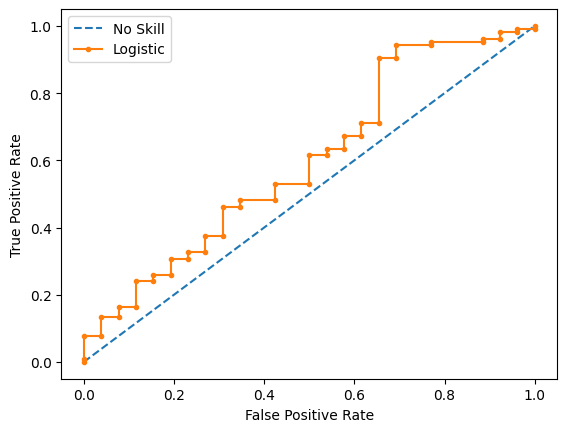

In [ ]:
# calculate scores
from sklearn.metrics import roc_curve
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_n_hate_test, pred_no_hate)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

from numpy import argmax
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

print(classification_report(y_n_hate_test, (pred_no_hate > best_thresh).astype(int)))

Best Threshold=0.693988
              precision    recall  f1-score   support

           0       0.45      0.35      0.39        26
           1       0.85      0.89      0.87       104

    accuracy                           0.78       130
   macro avg       0.65      0.62      0.63       130
weighted avg       0.77      0.78      0.77       130



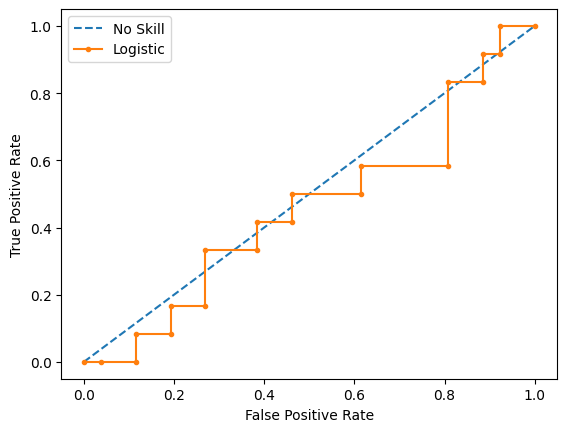

In [ ]:
# calculate scores
from sklearn.metrics import roc_curve
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_hate_test, pred_hate)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [ ]:
from sklearn.metrics import classification_report

from numpy import argmax
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

print(classification_report(y_hate_test, (pred_hate > best_thresh).astype(int)))

Best Threshold=0.070097
              precision    recall  f1-score   support

           0       0.67      0.08      0.14        26
           1       0.31      0.92      0.47        12

    accuracy                           0.34        38
   macro avg       0.49      0.50      0.30        38
weighted avg       0.56      0.34      0.24        38



## Bulid Unique Model (Disagreement Detection)

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import json
import os
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [ ]:
X_train = df['bert'].apply(pd.Series)
X_test = df_test['bert'].apply(pd.Series)

#X_train[768] = df['pred']
X_train[769] = df['agreement']

#X_test[768] = df_test['pred']
X_test[769] = df_test['agreement']

y_train = df['agreement']
y_test = df_test['agreement']

del X_train[769]
del X_test[769]

print(f'Dataset Train Shape: {X_train.shape}')
print(f'Dataset Test Shape: {X_test.shape}')

Dataset Train Shape: (2320, 768)
Dataset Test Shape: (815, 768)


In [ ]:
def get_model_tot(input_shape=768, activation_function='relu', neurons=768, dropout=0.5, lr=0.008, epsilon=1e-7):
    """ Builds the model with various parameters.
    Return the compiled model.
    :return: compiled model
    """
    model = Sequential()
    model.add(layers.Dense(int(neurons), input_shape=(input_shape,), activation=activation_function))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(int(neurons/2), activation=activation_function))
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1, activation='sigmoid'))

    opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=epsilon)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model_tot = get_model_tot(input_shape = X_train.shape[1], neurons = X_train.shape[1])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

import random
random.seed(400)
history_tot = model_tot.fit(X_train,
                    y_train,
                    epochs=50,
                    verbose=1,
                    batch_size=128,
                    validation_split = 0.1,
                    callbacks=[es])

Epoch 1/50
17/17 [==============================] - 1s 36ms/step - loss: 0.9881 - accuracy: 0.7754 - val_loss: 0.4245 - val_accuracy: 0.8707
Epoch 2/50
17/17 [==============================] - 0s 25ms/step - loss: 0.4260 - accuracy: 0.8582 - val_loss: 0.3797 - val_accuracy: 0.8707
Epoch 3/50
17/17 [==============================] - 0s 26ms/step - loss: 0.4047 - accuracy: 0.8582 - val_loss: 0.3654 - val_accuracy: 0.8707
Epoch 4/50
17/17 [==============================] - 0s 25ms/step - loss: 0.4115 - accuracy: 0.8587 - val_loss: 0.3907 - val_accuracy: 0.8707
Epoch 5/50
17/17 [==============================] - 0s 25ms/step - loss: 0.3951 - accuracy: 0.8587 - val_loss: 0.3611 - val_accuracy: 0.8707
Epoch 6/50
17/17 [==============================] - 0s 25ms/step - loss: 0.3956 - accuracy: 0.8587 - val_loss: 0.3646 - val_accuracy: 0.8707
Epoch 7/50
17/17 [==============================] - 0s 24ms/step - loss: 0.4032 - accuracy: 0.8587 - val_loss: 0.3629 - val_accuracy: 0.8707
Epoch 8/50
17

26/26 [==============================] - 0s 4ms/step


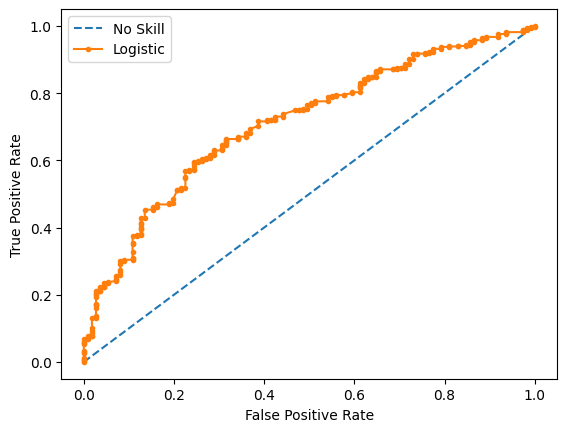

Best Threshold=0.878979
              precision    recall  f1-score   support

           0       0.23      0.76      0.35       111
           1       0.94      0.59      0.73       704

    accuracy                           0.62       815
   macro avg       0.58      0.68      0.54       815
weighted avg       0.84      0.62      0.68       815



In [ ]:
pred_tot = model_tot.predict(X_test)

# calculate scores
from sklearn.metrics import roc_curve
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, pred_tot)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

from sklearn.metrics import classification_report

from numpy import argmax
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

print(classification_report(y_test, (pred_tot > best_thresh).astype(int)))